In [3]:
#Data wrangling
import pandas as pd
import numpy as np
import re

#Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

## Data Import

In [4]:
train_df = pd.read_csv(r'C:\Users\Gonzalo\Documents\DH\Contenido\ds_blend_students_2020\Proyectos Propios\Prediction Models\Titanic Kaggle\Data\train.csv')
test_df = pd.read_csv(r'C:\Users\Gonzalo\Documents\DH\Contenido\ds_blend_students_2020\Proyectos Propios\Prediction Models\Titanic Kaggle\Data\test.csv')

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### General Data Analysis - Data structure

#### Duplicates - Describe

In [7]:
train_df.describe(include = 'O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Moss, Mr. Albert Johan",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


#### Missing Values - Info()

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
round((train_df.isnull().sum()/train_df.shape[0]*100).sort_values(ascending=False),2)

Cabin          77.10
Age            19.87
Embarked        0.22
Fare            0.00
Ticket          0.00
Parch           0.00
SibSp           0.00
Sex             0.00
Name            0.00
Pclass          0.00
Survived        0.00
PassengerId     0.00
dtype: float64

In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [11]:
round((test_df.isnull().sum()/test_df.shape[0]*100).sort_values(ascending=False),2)

Cabin          78.23
Age            20.57
Fare            0.24
Embarked        0.00
Ticket          0.00
Parch           0.00
SibSp           0.00
Sex             0.00
Name            0.00
Pclass          0.00
PassengerId     0.00
dtype: float64

### Hipotesis hasta el momento

**Feature Selection**
1. PassengerID does not seem to bring any relevant information that could be used in the modeling process. It will probably be dropped.
2. 80% of all the values of the Cabin feature are missing. If the missing values are not biased, it will be dropped.
3. We have to analyze and see if Name and Ticket add any valuable information to the analysis, otherwise they will be dropped.

**Feature Engineering**
1. 20% of the Age feature are missing, but we believe it might be highly correlated with survival rate, which would make it a relevant variable. Analyze how this feature can be completed.
2. Embarked has some missing values, but not too many. We can probably complete it with the mean input method.

**Feature Creation**
1. As the features Parch and SibSP have to do with family, we could create a new feature that groups the two.

**Observations**
1. There are more male than female passengers, but their survival rate is much lower.
2. Age: The children had a greater survival rate than the rest of the sample.

### Columnas a Droppear

PassagerId will be dropped, as it does not add any valuable information to the analysis.

In [12]:
#train_df.drop('PassengerId', inplace=True, axis=1)

#### Analisis drop Cabin

Let's check if the missing values are biased:

In [13]:
mask = train_df['Cabin'].isnull()

train_df[mask].groupby(by=['Sex']).mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,,
female,420.281106,0.654378,2.576037,25.207602,0.764977,0.709677,25.554782
male,453.793617,0.136170,2.668085,28.676676,0.446809,0.206383,16.203606


In [14]:
train_df.groupby(by='Sex').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,,
female,431.028662,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818
male,454.147314,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893


It seems that there is not an identifiable pattern in the missing values of Cabin, which would make it safe to drop the feature. 

In [15]:
train_df.drop('Cabin', inplace=True, axis=1)
test_df.drop('Cabin', inplace=True, axis=1)

### Analisis Correlacion entre variables

#### Heatmap

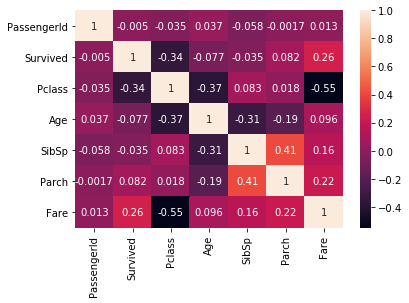

In [16]:
sns.heatmap(data=train_df.corr(),annot=True)

- Parch y SibSp seem to be highly correlated, but are not too correlated to the target variable. It might be a good idea to join the two in a new feature.
- Pclass seems to have a significant negative correlation with the target variable. 
- Fare seems to be quite correlated with Survived as well.

#### Correlation Scatterplot

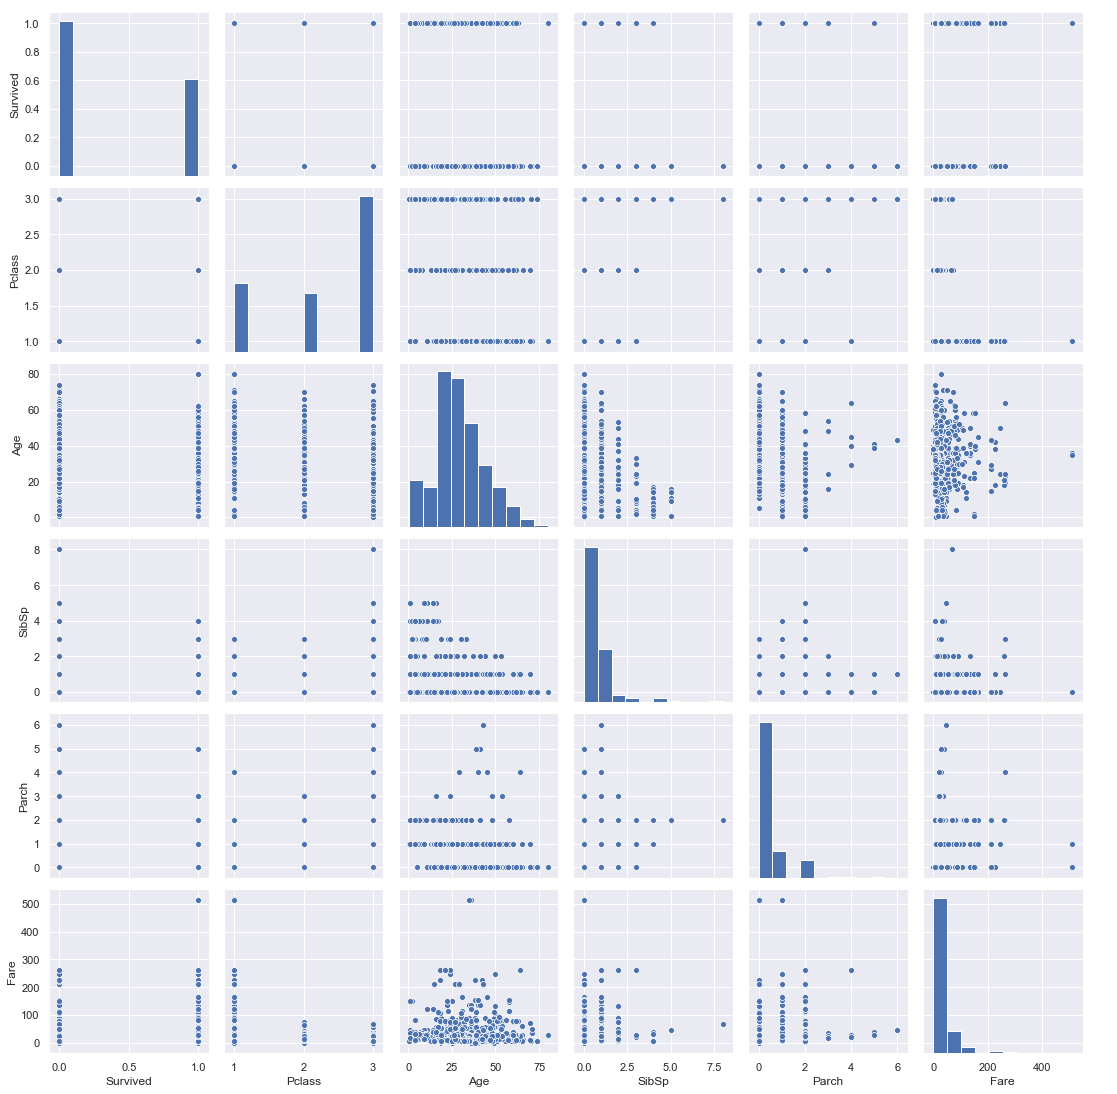

In [17]:
#scatterplot
sns.set()
cols = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
sns.pairplot(train_df[cols], height = 2.5)
plt.show();

### Analysis Variables - Feature Engineering

### Analysis Sex

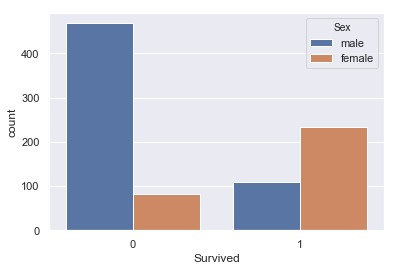

In [18]:
sns.countplot(x= 'Survived', hue= 'Sex', data=train_df)

**DECISIONS**:

Despite the fact the fact that there wer more men on board (600 men, 350 women), more women than men survived the crash, which makes this feature extremely significant. Conclusion: **Add the Sex Feature to the analysis**

### Mapping Sex Feature - Getting it ready for modeling

In [19]:
train_df.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [20]:
test_df.Sex.value_counts()

male      266
female    152
Name: Sex, dtype: int64

In [21]:
def map_sex(df):
    df.Sex = df.Sex.replace({'male':0,'female':1})
    return df.head()

In [22]:
map_sex(train_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,S


In [23]:
map_sex(test_df)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,S


In [24]:
train_df.Sex.value_counts()

0    577
1    314
Name: Sex, dtype: int64

In [25]:
test_df.Sex.value_counts()

0    266
1    152
Name: Sex, dtype: int64

**DECISIONS**:

**Sex feature is ready for modeling**

### Age Analysis 

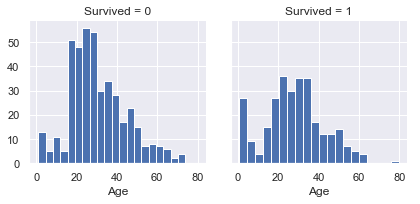

In [26]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

**DECISIONS**:

We can see that people who were between the ages of 18 to 30 were quite more likely to die. On the other hand, we can see that the infants had much higher chances of survival. The feature is therefore, relevant. Conclusions: **Input or drop the Age feature missing values to have it ready for modeling**

##### Relleno Variable Age

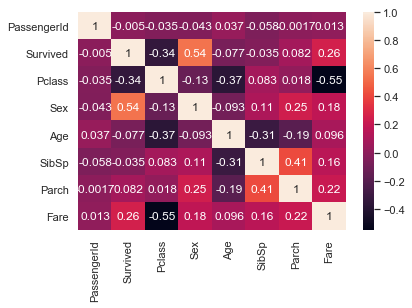

In [27]:
# Let's check for absolute correlation with Age:
sns.heatmap(data=train_df.corr(),annot=True)

In [28]:
mask1 = train_df.Sex == 1
train_df[mask1]['Sex']

1      1
2      1
3      1
8      1
9      1
      ..
880    1
882    1
885    1
887    1
888    1
Name: Sex, Length: 314, dtype: int64

In [1]:
# As the correlation with Age is the highest for Pclass and SubSp, we will use these two features to input the missing values.
def fill_missing_age(df):
    for m in range(0,max(df.SibSp)+1):
        for c in range(1,max(df.Pclass)+1):
            mask = (df['SibSp'] == m) & (df['Pclass'] == c) 
            age_mean = (df[mask]['Age'].mean())
            mask1 = (df['SibSp'] == m) & (df['Pclass'] == c) & (df['Age'].isnull())
            #print(df[mask1]['Age'],'and the age mean is', age_mean)
            df.loc[mask1,'Age'] = df[mask1]['Age'].fillna(age_mean)
  
        

In [30]:
fill_missing_age(train_df)
fill_missing_age(test_df)

In [31]:
round((train_df.isnull().sum()/train_df.shape[0]*100).sort_values(ascending=False),2)

Age            0.79
Embarked       0.22
Fare           0.00
Ticket         0.00
Parch          0.00
SibSp          0.00
Sex            0.00
Name           0.00
Pclass         0.00
Survived       0.00
PassengerId    0.00
dtype: float64

In [32]:
round((test_df.isnull().sum()/test_df.shape[0]*100).sort_values(ascending=False),2)

Fare           0.24
Embarked       0.00
Ticket         0.00
Parch          0.00
SibSp          0.00
Age            0.00
Sex            0.00
Name           0.00
Pclass         0.00
PassengerId    0.00
dtype: float64

In [33]:
train_df[train_df['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",0,NaN,8,2,CA. 2343,69.55,S
180,181,0,3,"Sage, Miss. Constance Gladys",1,NaN,8,2,CA. 2343,69.55,S
201,202,0,3,"Sage, Mr. Frederick",0,NaN,8,2,CA. 2343,69.55,S
324,325,0,3,"Sage, Mr. George John Jr",0,NaN,8,2,CA. 2343,69.55,S
792,793,0,3,"Sage, Miss. Stella Anna",1,NaN,8,2,CA. 2343,69.55,S
846,847,0,3,"Sage, Mr. Douglas Bullen",0,NaN,8,2,CA. 2343,69.55,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",1,NaN,8,2,CA. 2343,69.55,S


As no passengers with PClass = 3 and SibSP = 8 have the Age value filled, the age_mean cannot be calculated. As they make just 0.79% of the entire sample, we can input the values with the sample mean.

In [34]:
train_df.loc[train_df['Age'].isnull(),'Age'] = train_df.Age.mean()

In [35]:
round((train_df.isnull().sum()/train_df.shape[0]*100).sort_values(ascending=False),2)

Embarked       0.22
Fare           0.00
Ticket         0.00
Parch          0.00
SibSp          0.00
Age            0.00
Sex            0.00
Name           0.00
Pclass         0.00
Survived       0.00
PassengerId    0.00
dtype: float64

In [36]:
train_df['Age'].mean()

29.55876106060841

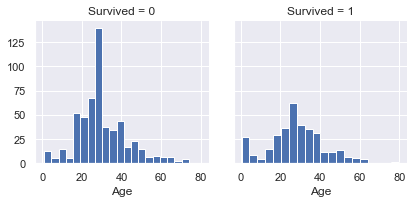

In [37]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

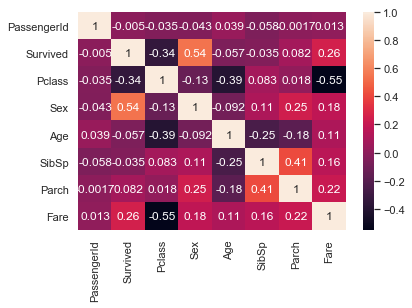

In [38]:
sns.heatmap(data=train_df.corr(),annot=True)

In [39]:
train_df['Age'].std()

13.238949120797198

We did not lose as much variance as we had expected, great!

##### Age vs SibSp vs Pclass

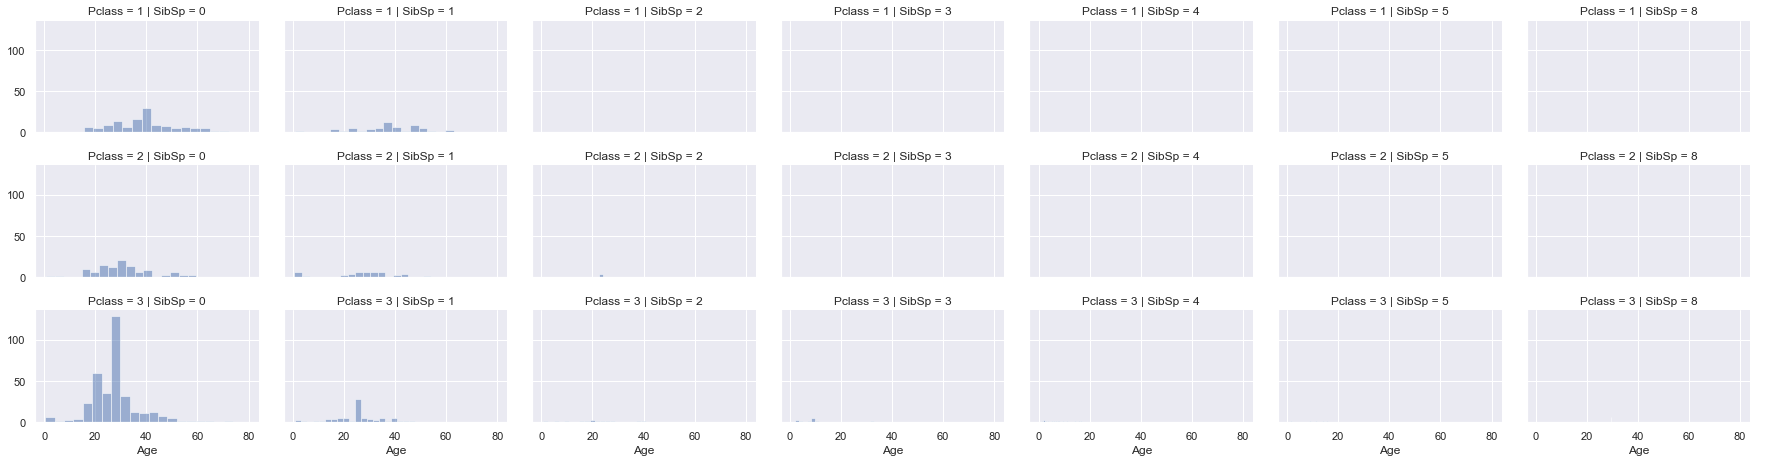

In [40]:
grid = sns.FacetGrid(train_df, col='SibSp', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

### Pclass Feature Analysis

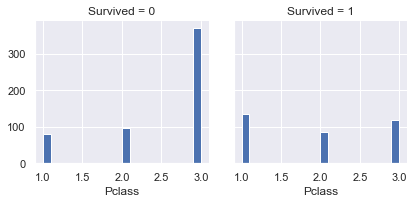

In [42]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Pclass', bins=20)

**DECISIONS**:

We can see that the passengers travelling in Pclass = 3 had a slimmer chance of success, while the passengers travelling in Pclass = 1 were much more likely to survive. All of this makes this feature quite relevant for the analysis. Conclusion: **Add Pclass to the Analysis**.

### Parch y SibSp Analysis

##### Survived vs Parch

In [43]:
train_df[['Survived','Parch']].groupby(by='Parch').mean()

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


##### Survived vs SibSp

In [44]:
train_df[['Survived','SibSp']].groupby(by='SibSp').mean()

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


**DECISIONS**: Add the features to the analysis

### Analysis Ticket - Ticket_RE feature creation

In [45]:
train_df[['Ticket','Survived']].head(20)

,Ticket,Survived
0,A/5 21171,0
1,PC 17599,1
2,STON/O2. 3101282,1
3,113803,1
4,373450,0
5,330877,0
6,17463,0
7,349909,0
8,347742,1
9,237736,1


In [46]:
pattern = '\d+$'

regex_ticket = re.compile(pattern)

train_df['ticket_re'] = train_df['Ticket'].apply(lambda x: x if x is None else regex_ticket.findall(x))

In [47]:
mask1 = (train_df['ticket_re'] =='')
train_df['ticket_re'] = train_df['ticket_re'].map(lambda x: ''.join(x))
train_df['ticket_re'] = train_df['ticket_re'].replace(to_replace='',value=111111)
train_df['ticket_re'].head()

train_df['ticket_re'] = train_df['ticket_re'].map(lambda x: int(x))

In [48]:
train_df.drop('Ticket',inplace=True, axis=1)

#### DECISIONS 
**The feature is ready for modeling** after we apply the analysis to the test_df

### Embarked feature Analysis

Less than 1% of it's values are missing, so we will input them using the sample mean.

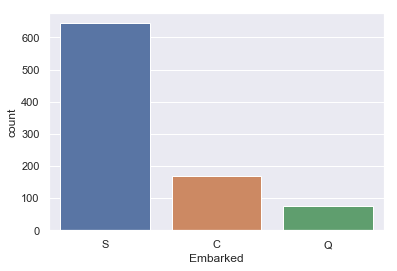

In [49]:
sns.countplot(x='Embarked',data=train_df)

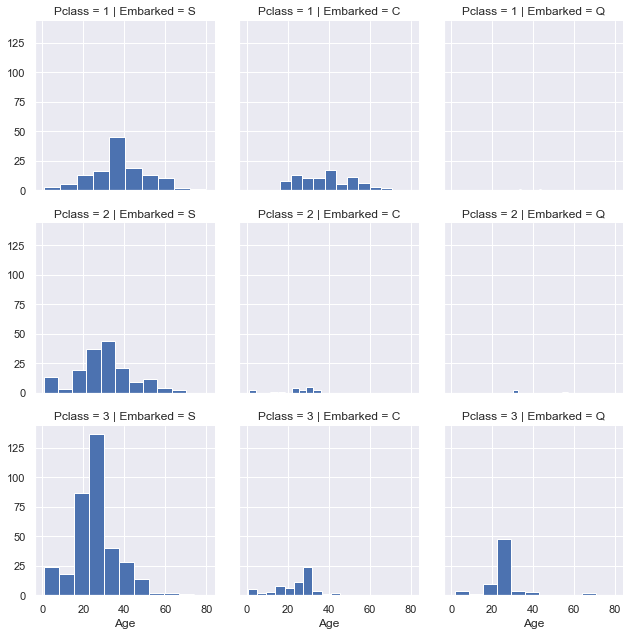

In [50]:
g = sns.FacetGrid(data=train_df,row= 'Pclass', col='Embarked')
g.map(plt.hist,'Age')

In [51]:
train_df.groupby(['Embarked']).mean()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,ticket_re
Embarked,,,,,,,,,
C,445.357143,0.553571,1.886905,0.434524,30.737467,0.386905,0.363095,59.954144,33724.250000
Q,417.896104,0.389610,2.909091,0.467532,27.343291,0.428571,0.168831,13.276030,290896.428571
S,449.527950,0.336957,2.350932,0.315217,29.452683,0.571429,0.413043,27.079812,367655.135093


In [52]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [53]:
train_df['Embarked'].fillna(value= train_df['Embarked'].mode()[0],inplace=True)

In [54]:
train_df['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [55]:
round((train_df.isnull().sum()/train_df.shape[0]*100).sort_values(ascending=False),2)

ticket_re      0.0
Embarked       0.0
Fare           0.0
Parch          0.0
SibSp          0.0
Age            0.0
Sex            0.0
Name           0.0
Pclass         0.0
Survived       0.0
PassengerId    0.0
dtype: float64

In [56]:
train_df.Embarked = train_df['Embarked'].replace({'S':0,'C':1,'Q':2})
test_df.Embarked = test_df['Embarked'].replace({'S':0,'C':1,'Q':2})

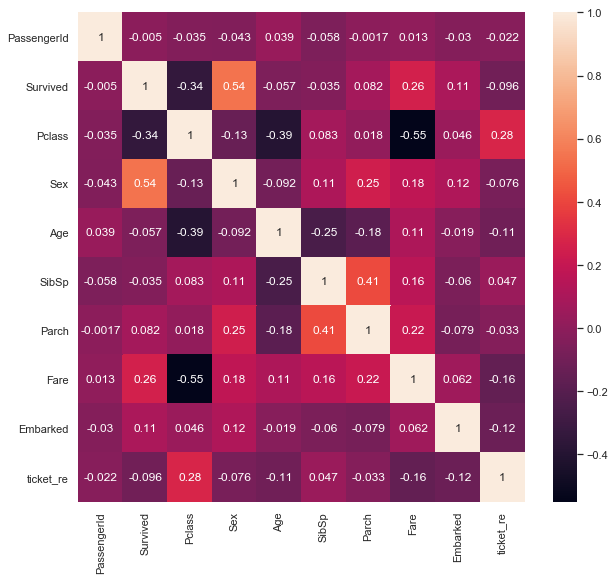

In [57]:
plt.subplots(figsize=(10,9))
sns.heatmap(data=train_df.corr(),annot=True)

### Fare Feature Analysis

(array([732., 106.,  31.,   2.,  11.,   6.,   0.,   0.,   0.,   3.]),
 array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
        307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
 <a list of 10 Patch objects>)

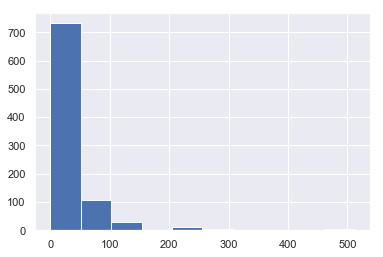

In [58]:
plt.hist(x='Fare',data=train_df)

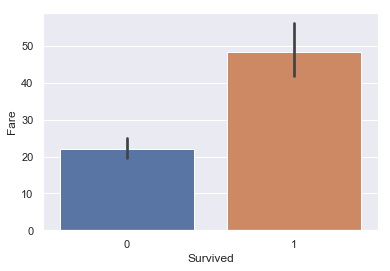

In [59]:
sns.barplot(data=train_df,x='Survived',y='Fare')

In [60]:
train_df[['Survived','Fare']].groupby('Survived').mean()

,Fare
Survived,
0,22.117887
1,48.395408


The mean price of the Fare paid for the portion of the sample that survived is much higher. 

#### DECISIONS: Add Fare Feature to the Analysis

### Name Feature Analysis 

In [61]:
train_df['Name'].describe()

count                        891
unique                       891
top       Moss, Mr. Albert Johan
freq                           1
Name: Name, dtype: object

In [62]:
train_df[['Name','Survived']].head(30)

,Name,Survived
0,"Braund, Mr. Owen Harris",0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1
2,"Heikkinen, Miss. Laina",1
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1
4,"Allen, Mr. William Henry",0
5,"Moran, Mr. James",0
6,"McCarthy, Mr. Timothy J",0
7,"Palsson, Master. Gosta Leonard",0
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1
9,"Nasser, Mrs. Nicholas (Adele Achem)",1


The Title is probably useful to predict other variables: 
1. Sex 
2. Economic Status and thus the Fare paid
3. Pclass

Let's extract it from the Name Feature.

##### Title Regex - Feature Creation using the Name Variable

In [63]:
pattern_title = '[A-z]+\.'

regex_title = re.compile(pattern_title)

train_df['Title'] = train_df['Name'].apply(lambda x: x if x is None else regex_title.findall(x)).astype(str)

In [64]:
train_df['Title'].value_counts()

['Mr.']           517
['Miss.']         182
['Mrs.']          124
['Master.']        40
['Dr.']             7
['Rev.']            6
['Col.']            2
['Mlle.']           2
['Major.']          2
['Ms.']             1
['Mrs.', 'L.']      1
['Capt.']           1
['Mme.']            1
['Don.']            1
['Sir.']            1
['Jonkheer.']       1
['Lady.']           1
['Countess.']       1
Name: Title, dtype: int64

Let's keep the 4 categories that show up the most, and group the rest.

In [65]:
train_df['Title'] = train_df['Title'].replace(["['Dr.']","['Rev.']","['Col.']","['Mlle.']","['Major.']","['Lady.']","['Countess.']","['Sir.']","['Ms.']","['Don.']",\
"['Ls.']","['Jonkheer.']","['Capt.']","['Mme.']"],'Rare')

train_df['Title'] = train_df['Title'].replace("['Mrs.', 'L.']",'Mrs')
train_df['Title'] = train_df['Title'].replace("['Mrs.']",'Mrs')
train_df['Title'] = train_df['Title'].replace("['Miss.']",'Miss')
train_df['Title'] = train_df['Title'].replace("['Master.']",'Master')
train_df['Title'] = train_df['Title'].replace("['Mr.']",'Mr')

In [66]:
train_df[['Survived','Title']].groupby('Title').mean().sort_values(by='Survived',ascending=False)

,Survived
Title,
Mrs,0.792000
Miss,0.697802
Master,0.575000
Rare,0.444444
Mr,0.156673


##### Let's map the titles for the modeling

In [67]:
train_df['Title'] = train_df['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})

In [68]:
train_df = train_df.drop('Name',axis=1)

In [69]:
train_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,ticket_re,Title
0,1,0,3,0,22.000000,1,0,7.2500,0,21171,1
1,2,1,1,1,38.000000,1,0,71.2833,1,17599,3
2,3,1,3,1,26.000000,0,0,7.9250,0,3101282,2
3,4,1,1,1,35.000000,1,0,53.1000,0,113803,3
4,5,0,3,0,35.000000,0,0,8.0500,0,373450,1
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.000000,0,0,13.0000,0,211536,5
887,888,1,1,1,19.000000,0,0,30.0000,0,112053,2
888,889,0,3,1,24.912698,1,2,23.4500,0,6607,2
889,890,1,1,0,26.000000,0,0,30.0000,1,111369,1


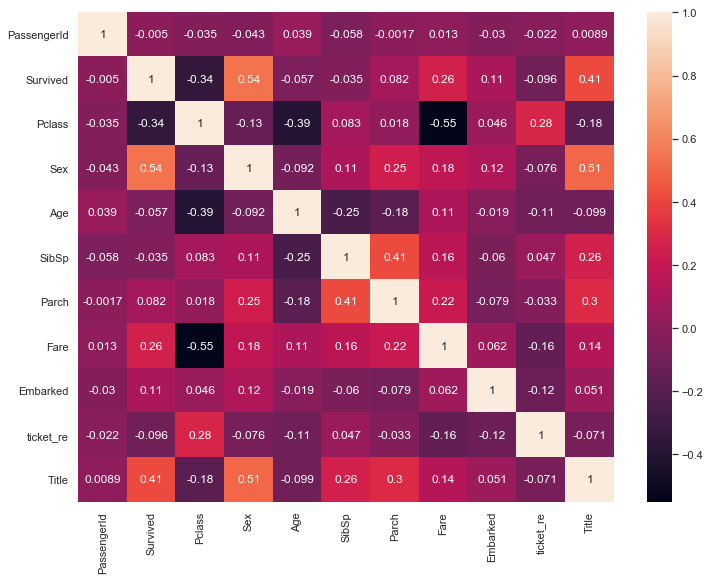

In [70]:
plt.figure(figsize=(12,9))
sns.heatmap(train_df.corr(),annot=True)

##### The only task left is to apply regex and transformations to the test_df 

In [71]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",0,34.500000,0,0,330911,7.8292,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.000000,1,0,363272,7.0000,0
2,894,2,"Myles, Mr. Thomas Francis",0,62.000000,0,0,240276,9.6875,2
3,895,3,"Wirz, Mr. Albert",0,27.000000,0,0,315154,8.6625,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.000000,1,1,3101298,12.2875,0
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",0,25.692000,0,0,A.5. 3236,8.0500,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",1,39.000000,0,0,PC 17758,108.9000,1
415,1307,3,"Saether, Mr. Simon Sivertsen",0,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,0
416,1308,3,"Ware, Mr. Frederick",0,25.692000,0,0,359309,8.0500,0


In [72]:
#test_df.drop('PassengerId',inplace=True,axis=1)

In [73]:
pattern = '\d+$'

regex_ticket = re.compile(pattern)

test_df['ticket_re'] = test_df['Ticket'].apply(lambda x: x if x is None else regex_ticket.findall(x))

In [74]:
mask1 = (test_df['ticket_re'] =='')
test_df['ticket_re'] = test_df['ticket_re'].map(lambda x: ''.join(x))
test_df['ticket_re'] = test_df['ticket_re'].replace(to_replace='',value=111111)
test_df['ticket_re'].head()

test_df['ticket_re'] = test_df['ticket_re'].map(lambda x: int(x))

In [75]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,ticket_re
0,892,3,"Kelly, Mr. James",0,34.500000,0,0,330911,7.8292,2,330911
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.000000,1,0,363272,7.0000,0,363272
2,894,2,"Myles, Mr. Thomas Francis",0,62.000000,0,0,240276,9.6875,2,240276
3,895,3,"Wirz, Mr. Albert",0,27.000000,0,0,315154,8.6625,0,315154
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.000000,1,1,3101298,12.2875,0,3101298
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",0,25.692000,0,0,A.5. 3236,8.0500,0,3236
414,1306,1,"Oliva y Ocana, Dona. Fermina",1,39.000000,0,0,PC 17758,108.9000,1,17758
415,1307,3,"Saether, Mr. Simon Sivertsen",0,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,0,3101262
416,1308,3,"Ware, Mr. Frederick",0,25.692000,0,0,359309,8.0500,0,359309


In [76]:
test_df.drop('Ticket',inplace=True, axis=1)

In [77]:
pattern_title = '[A-z]+\.'

regex_title = re.compile(pattern_title)

test_df['Title'] = test_df['Name'].apply(lambda x: x if x is None else regex_title.findall(x)).astype(str)

In [78]:
test_df['Title'].value_counts()

['Mr.']        240
['Miss.']       78
['Mrs.']        72
['Master.']     21
['Rev.']         2
['Col.']         2
['Dr.']          1
['Dona.']        1
['Ms.']          1
Name: Title, dtype: int64

Quedemonos con las 5 categorias mas comunes, agrupemos los menos comunes en una sola.

In [79]:
test_df['Title'] = test_df['Title'].replace(["['Dr.']","['Rev.']","['Col.']","['Mlle.']","['Major.']","['Lady.']","['Countess.']","['Sir.']","['Ms.']","['Don.']",\
"['Ls.']","['Jonkheer.']","['Capt.']","['Mme.']"],'Rare')

test_df['Title'] = test_df['Title'].replace("['Mrs.', 'L.']",'Mrs')
test_df['Title'] = test_df['Title'].replace("['Mrs.']",'Mrs')
test_df['Title'] = test_df['Title'].replace("['Miss.']",'Miss')
test_df['Title'] = test_df['Title'].replace("['Master.']",'Master')
test_df['Title'] = test_df['Title'].replace("['Mr.']",'Mr')

In [80]:
test_df['Title'] = test_df['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})

In [81]:
test_df['Title'].value_counts()

1.0    240
2.0     78
3.0     72
4.0     21
5.0      6
Name: Title, dtype: int64

In [82]:
test_df.drop('Name',inplace=True,axis=1)

In [83]:
test_df

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,ticket_re,Title
0,892,3,0,34.500000,0,0,7.8292,2,330911,1.0
1,893,3,1,47.000000,1,0,7.0000,0,363272,3.0
2,894,2,0,62.000000,0,0,9.6875,2,240276,1.0
3,895,3,0,27.000000,0,0,8.6625,0,315154,1.0
4,896,3,1,22.000000,1,1,12.2875,0,3101298,3.0
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,0,25.692000,0,0,8.0500,0,3236,1.0
414,1306,1,1,39.000000,0,0,108.9000,1,17758,NaN
415,1307,3,0,38.500000,0,0,7.2500,0,3101262,1.0
416,1308,3,0,25.692000,0,0,8.0500,0,359309,1.0


In [84]:
test_df['Fare'] = test_df['Fare'].fillna(method='ffill')

In [85]:
test_df['Title'] = test_df['Title'].fillna(method='bfill')

In [86]:
test_df['Title'] = test_df['Title'].astype('int')

In [87]:
test_df

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,ticket_re,Title
0,892,3,0,34.500000,0,0,7.8292,2,330911,1
1,893,3,1,47.000000,1,0,7.0000,0,363272,3
2,894,2,0,62.000000,0,0,9.6875,2,240276,1
3,895,3,0,27.000000,0,0,8.6625,0,315154,1
4,896,3,1,22.000000,1,1,12.2875,0,3101298,3
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,0,25.692000,0,0,8.0500,0,3236,1
414,1306,1,1,39.000000,0,0,108.9000,1,17758,1
415,1307,3,0,38.500000,0,0,7.2500,0,3101262,1
416,1308,3,0,25.692000,0,0,8.0500,0,359309,1


In [88]:
train_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,ticket_re,Title
0,1,0,3,0,22.000000,1,0,7.2500,0,21171,1
1,2,1,1,1,38.000000,1,0,71.2833,1,17599,3
2,3,1,3,1,26.000000,0,0,7.9250,0,3101282,2
3,4,1,1,1,35.000000,1,0,53.1000,0,113803,3
4,5,0,3,0,35.000000,0,0,8.0500,0,373450,1
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.000000,0,0,13.0000,0,211536,5
887,888,1,1,1,19.000000,0,0,30.0000,0,112053,2
888,889,0,3,1,24.912698,1,2,23.4500,0,6607,2
889,890,1,1,0,26.000000,0,0,30.0000,1,111369,1


In [89]:
train_df.drop('ticket_re',axis=1,inplace=True)
test_df.drop('ticket_re',axis=1,inplace=True)

# Modeling

In [90]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split

#Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [91]:
X_train, X_test, Y_train, Y_test = train_test_split(train_df.drop(['Survived','PassengerId'],axis=1),train_df['Survived'],test_size=0.2)

### Vector Creation

### Naive Bayes

In [92]:
#Instantiate 
gnb = GaussianNB()

#Training the Model - Fit
gnb.fit(X_train, Y_train)

#Predicting with the model
Y_pred_gnb = gnb.predict(X_test)

#Measure accuracy
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, Y_pred_gnb)

(107+42) / (107+17+13+42) * 100
accuracy_score(Y_test, Y_pred_gnb)

0.7877094972067039

### KNN

In [93]:
#Instantiate 
knn = KNeighborsClassifier()

#Training the Model - Fit
knn.fit(X_train,Y_train)

#Predicting with the model
Y_pred_knn = knn.predict(X_test)

#Measure accuracy
accuracy_score(Y_test, Y_pred_knn)

0.7486033519553073

### Logistic Regression

In [99]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, Y_train)
Y_pred_logreg = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

accuracy_score(Y_test, Y_pred_logreg)

0.8212290502793296

### Decision Tree

In [95]:
#Instantiate 
dec_tree = DecisionTreeClassifier()

#Training the Model - Fit
dec_tree.fit(X_train,Y_train)

#Predicting with the model
Y_pred_dec_tree = dec_tree.predict(X_test)

#Measure accuracy
acc_DT = dec_tree.score(X_train,Y_train)*100

accuracy_score(Y_test, Y_pred_dec_tree)

0.8044692737430168

### Random Forest

In [96]:
#Instantiate 
random_forest = RandomForestClassifier()

#Training the Model - Fit
random_forest.fit(X_train,Y_train)

#Predicting with the model
Y_pred_RF = random_forest.predict(X_test)

#Measure accuracy
acc_RF = random_forest.score(X_train,Y_train)*100

accuracy_score(Y_test, Y_pred_RF)

0.8100558659217877